In [11]:
from Pers_utils.Ramp import Ramp
from cPers_utils.cPixTraps import cPixTraps as PixTraps
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from Pers_utils.GeneralRandom import GeneralRandom
from scipy.stats import beta,powerlaw
import time

%matplotlib notebook

<IPython.core.display.Javascript object>


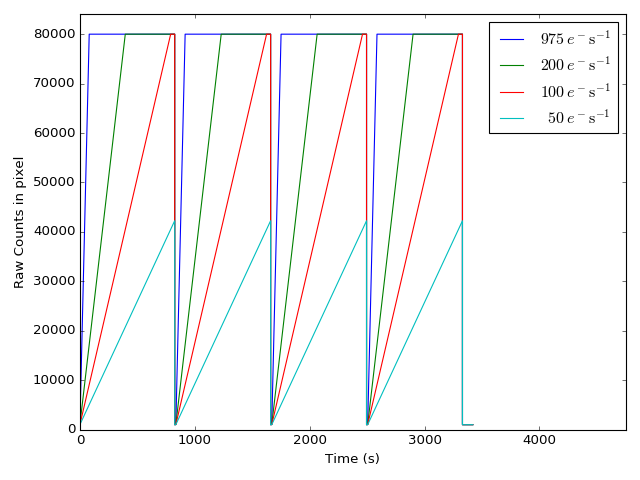

In [12]:
#Create test ramps and plot them

plt.close("all")

myramp1 = Ramp(975,825,4,57*60)
myramp1.test_plot(label=r'$975 \,e^-\mathrm{s^{-1}}$')

myramp2 = Ramp(200,825,4,57*60)
myramp2.test_plot(label=r'$200 \,e^-\mathrm{s^{-1}}$')

myramp3 = Ramp(100,825,4,57*60)
myramp3.test_plot(label=r'$100 \,e^-\mathrm{s^{-1}}$')

myramp4 = Ramp(50,825,4,57*60)
myramp4.test_plot(label=r'$ \;\;50 \,e^-\mathrm{s^{-1}}$')

plt.xlim(0,4.75e3)
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


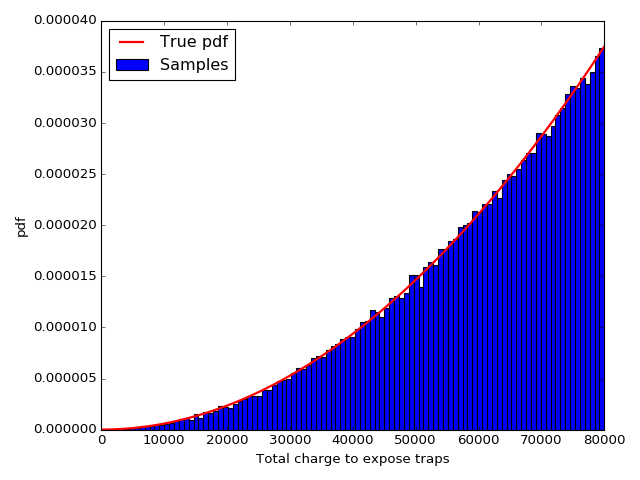

In [13]:
# Initialize the pixel(s) traps distribution
# as a function of accumulated charge 
# (i.e. this is the density of traps that are exposed to free
# charge at a given total charge level)

alpha = 2
ntraps = 1e5

rhotrap_dist = powerlaw(alpha+1,scale=80000)
x = np.arange(80000)
y = rhotrap_dist.pdf(x)

rhotrap = (rhotrap_dist.rvs(size=ntraps)).astype(np.int)
plt.close("all")
plt.hist(rhotrap,bins=100,normed=True,label='Samples');
plt.xlabel('Total charge to expose traps')
plt.ylabel('pdf')
plt.plot(x,y,label="True pdf",c='r',linewidth=2)
plt.legend(loc=2)
plt.tight_layout()

<IPython.core.display.Javascript object>


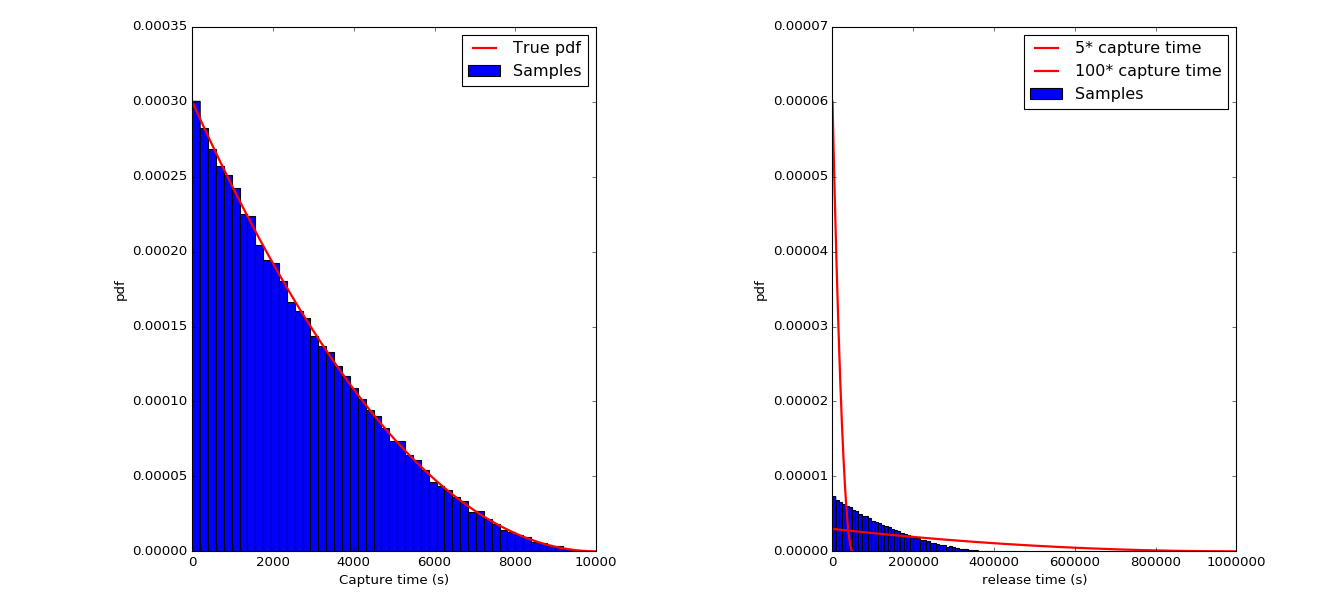

In [16]:
# Initialize the pixel(s) traps capture time distribution
# assume that release times are proportional to capture times

abeta = 1.
bbeta = 3.
tmin  = 1
tmax  = 1e4

tcap_dist = beta(abeta,bbeta,loc=tmin,scale=tmax-tmin)
x = np.arange(tmin,tmax)
y = tcap_dist.pdf(x)

tcap = tcap_dist.rvs(size=ntraps)

cfacmin = 5
cfacmax = 100
cfac = np.random.uniform(low=cfacmin,high=cfacmax)
trel = tcap*cfac

plt.close("all")
plt.subplot(121)
plt.hist(tcap,bins=50,label='Samples',normed=True);
plt.plot(x,y,label='True pdf',c='r',linewidth=2)
plt.legend(loc=1)
plt.xlabel('Capture time (s)')
plt.ylabel('pdf')

plt.subplot(122)
plt.hist(trel,bins=50,label='Samples',normed=True);
plt.plot(cfacmin*x,y/cfacmin,label= ("%.0f" %cfacmin)+'* capture time',c='r',linewidth=2)
plt.plot(cfacmax*x,y/cfacmax,label= ("%.0f" %cfacmax)+'* capture time',c='r',linewidth=2)

plt.legend(loc=1)
plt.xlabel('release time (s)')
plt.ylabel('pdf')

plt.tight_layout()

In [17]:
# Use these distributions to initialize the pixel

mypixel = PixTraps(tcap,trel,rhotrap)

In [18]:
# Test the differential method
plt.close("all")

times  = np.arange(0,50000,100)
tafter = np.arange(0,46500,100)

time0 = time.process_time()
ramps = [myramp1,myramp2,myramp3,myramp4]

ops = []
chs = []

for ramp in ramps:
    mypixel.reset()
    ops.append(mypixel.follow_occ_prob(ramp,times))
    chs.append(mypixel.get_trapped_charge_diff(ramp,tafter))
    
el_t = (time.process_time() - time0)/60
print('Elapsed_time (min)',el_t)   

Elapsed_time (min) 13.446074733333335


<IPython.core.display.Javascript object>


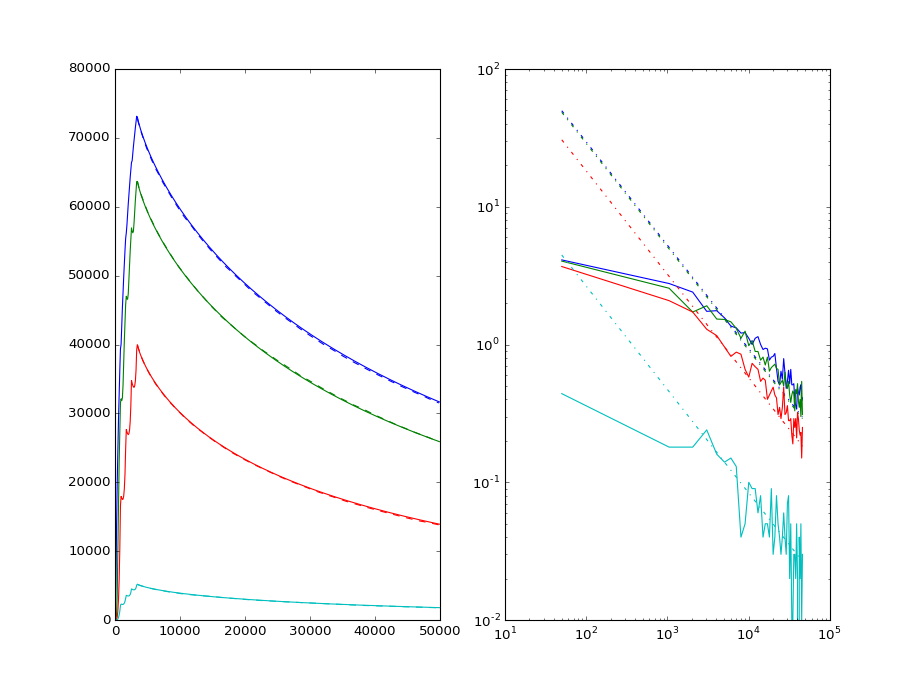

In [23]:
f   = plt.figure()
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
sml   = 10

for op,ch,ramp in zip(ops,chs,ramps):
    
    tp = np.sum(op,axis=0)
    x = ax1.plot(times,tp)
    color=x[0].get_color()
    ax1.plot(tafter+ramp.rtime[-1],ch,'--',color=color)

    ################
    
    dcdt = -1.*(ch[1::sml]-ch[:-1:sml])/(tafter[1::sml]-tafter[:-1:sml])
    dtcen = 0.5*(tafter[1::sml]+tafter[:-1:sml])
    
    offset = ramp.rtime[-1]
    
    ax2.plot(dtcen,dcdt,color=color)
 
    t0 = 5000
    gamma = .75
    ii = np.argmin(np.abs(dtcen-t0))
    t0 = dtcen[ii]
    Ak = dcdt[ii]*(t0**gamma)
    
    ax2.plot(dtcen,Ak*(dtcen)**(-1.*gamma),'-.',color=color)
    
ax2.set_yscale('log')
ax2.set_xscale('log')


<IPython.core.display.Javascript object>


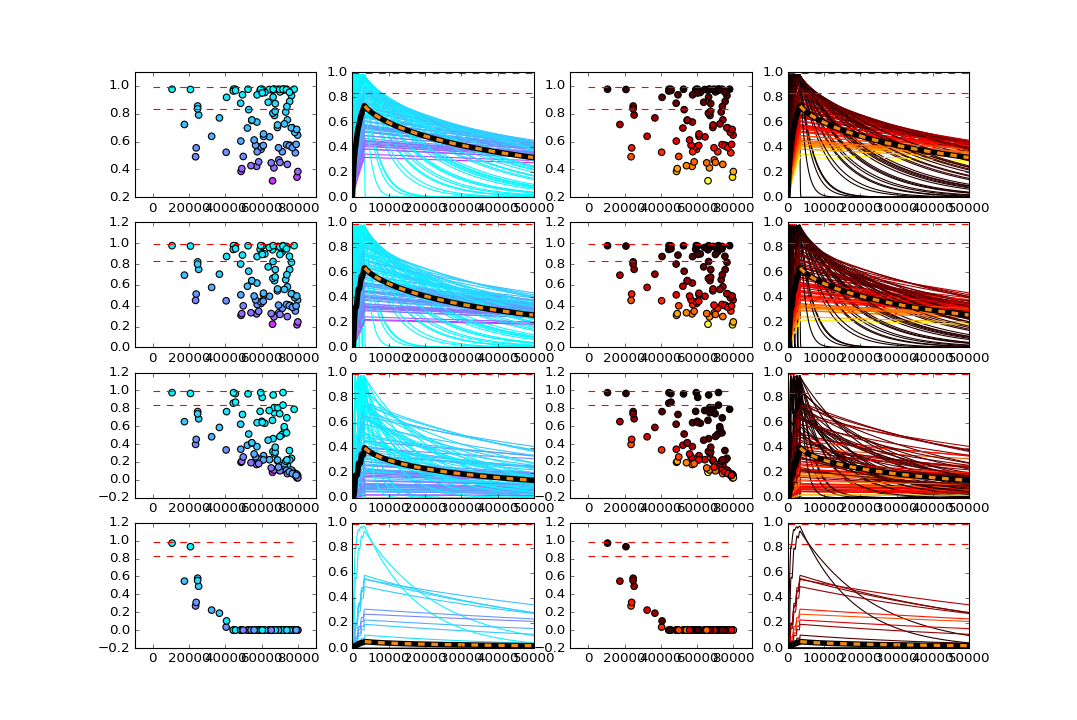

In [21]:
f = plt.figure()

step = 1000

for jj,op in enumerate(ops):
    
    ax1 = f.add_subplot(len(ops),4,1+4*jj)
    ax2 = f.add_subplot(len(ops),4,2+4*jj)
    ax3 = f.add_subplot(len(ops),4,3+4*jj)
    ax4 = f.add_subplot(len(ops),4,4+4*jj)

    cmap = plt.get_cmap('cool')
    colorsC = []
    tcmin  = np.amin(mypixel.t_trp)
    tcmax  = np.amax(mypixel.t_trp)
    colorsC = cmap((mypixel.t_trp-tcmin)/(tcmax-tcmin))

    cmap = plt.get_cmap('hot')
    colorsR = []
    trmin  = np.amin(mypixel.t_rel)
    trmax  = np.amax(mypixel.t_rel)
    colorsR = cmap((mypixel.t_rel-trmin)/(trmax-trmin))

    maxes = []
    for j in range(0,len(mypixel.cmin),step):
        maxes.append(np.amax(op[j,:]))
        ax2.plot(times,op[j,:],color=colorsC[j])
        ax4.plot(times,op[j,:],color=colorsR[j])

    ax2.plot(times,np.sum(op,axis=0)/op.shape[0],c='black',linewidth=5)
    ax4.plot(times,np.sum(op,axis=0)/op.shape[0],c='black',linewidth=5)

    ax1.scatter(mypixel.cmin[::step],maxes,c=colorsC[::step],s=35)
    ax1.plot([0,80000],[1-1/(1+cfacmin),1-1/(1.+cfacmin)],'--',c='r')        
    ax1.plot([0,80000],[1-1/(1+cfacmax),1-1/(1.+cfacmax)],'--',c='r')        
    
    ax3.scatter(mypixel.cmin[::step],maxes,c=colorsR[::step],s=35)
    ax3.plot([0,80000],[1-1/(1+cfacmin),1-1/(1.+cfacmin)],'--',c='r')        
    ax3.plot([0,80000],[1-1/(1+cfacmax),1-1/(1.+cfacmax)],'--',c='r')        

    ax2.plot(times,np.repeat([1-1/(1+cfacmin)],len(times)),'--',c='r')
    ax2.plot(times,np.repeat([1-1/(1+cfacmax)],len(times)),'--',c='r')
    ax4.plot(times,np.repeat([1-1/(1+cfacmin)],len(times)),'--',c='r')
    ax4.plot(times,np.repeat([1-1/(1+cfacmax)],len(times)),'--',c='r')

    tend = ramps[jj].rtime[-1] 
    tt = tend + tafter
    states = np.random.random_sample(size=len(mypixel.cmin))  < np.squeeze(mypixel.follow_occ_prob(ramps[jj],np.array([tend])))
   
    fx = np.zeros_like(tafter)
    for k in range(fx.size):
        fx[k] = np.sum(np.exp(-tafter[k]/mypixel.t_rel[states]))
    fx = fx/len(mypixel.t_trp)
    ax2.plot(tt,fx,'--',c='#ee8910',linewidth=3)       
    ax4.plot(tt,fx,'--',c='#ee8910',linewidth=3)       


In [ ]:
#Run the pixel through each ramp
#and get the persistence accumulated charge

time0 = time.process_time()
ramps   = [myramp1,myramp2,myramp3,myramp4]

times  = np.arange(0,7000,10)
charges = []
totfills = []

for ramp in ramps:
    mypixel.reset()
    mypixel.end_ramp_occ(ramp)
    totfills.append(mypixel.totfill)
    print('Total number of filled traps','%.0f' %totfills[-1][-1])
    charges.append(mypixel.get_trapped_charge(times))

    
el_t = (time.process_time() - time0)/60
print('Elapsed_time (min)',el_t)

In [ ]:
#Plot the evolution of the number of filled traps
plt.close("all")
for z in zip(ramps,totfills):
    plt.plot(z[0].rtime[1:],z[1]/ntraps,label=('%.0f' %z[0].rate))
    
plt.legend(loc=2)
plt.ylabel('Fraction of filled traps')
plt.xlabel('Time (s)')

In [ ]:
plt.close("all")


nrows = len(ramps)

f =  plt.figure()

ax1=f.add_subplot(121)
ax2=f.add_subplot(122)

for i,z in enumerate(zip(ramps,charges,totfills)):

    ramp = z[0]
    charge = z[1]
    totfill_end = z[2][-1]
    #print('%.0f' %ramp.rate)

    ############
    #Charge plot
    ############

    x = ax1.plot(times,charge)
    color=x[0].get_color()
#   ax1.plot(times,np.repeat(totfill_end,len(times)),'--',color=color)

    #Compare to power-law decay by making them agree at time t0 (current goes like t^-gamma)
    gamma = 2.75
    t0 = 1000
    tnorm = 1000

    ii     = np.argmin(np.abs(times-tnorm))
    tnormh = times[ii]    
    Qnorm  = charge[ii]
    Qplconst = Qnorm/(tnormh+t0)**(1-gamma)

    
    
#    Apl   = charge[ii]*(gamma-1)/((times[ii]+t0)**(1-gamma) - t0**(1-gamma))
#    pldecay = -1.* Apl/(1-gamma) * ((times+t0)**(1-gamma)-t0**(1-gamma))  
#    pldecay = mp-pldecay
    
    ax1.plot(times,Qplconst*(times+t0)**(1-gamma),'-.',color=color)


    ############
    #Current plot
    ############

    # Get a count rate
    sml  = 10
    dcdt = -(charge[1::sml]-charge[:-1:sml])/(times[1::sml]-times[:-1:sml])
    dtcen = 0.5*(times[1::sml]+times[:-1:sml])

    ii    = np.argmin(np.abs(dtcen-tnorm))

    tnormh = dtcen[ii]    
    Cnorm  = dcdt[ii]
    Cplconst = Cnorm/(tnormh+t0)**(-gamma)
    ax2.plot(dtcen,dcdt,color=color,label=(('%.0f' %ramp.rate) + r'$\,e^-\mathrm{s^{-1}}$'))
    ax2.plot(dtcen,Cplconst*dtcen**(-gamma),'-.',color=color)


ax1.set_xlabel("Time since the end of the exposure ramp")
ax1.set_ylabel('Trapped charge')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xlabel("Time since the end of the exposure ramp")
ax2.set_ylabel('Current'+ r'$\,e^-\mathrm{s^{-1}}$')
ax2.set_xlim(100,times[-1])
ax2.set_yscale('log')
ax2.set_xscale('log')

plt.legend()
plt.tight_layout()